In [ ]:
''' 
PPCA v1.0.4

STEP 4: POPULATION POTENTIAL PER BUILDING & PER CATCHMENT AREA

Author: Perez, Joan

This script estimates population distribution within residential buildings based on floor area. The script filters the buildings to retain
only residential types. Using the centroids of these buildings, it conducts a spatial join with the GHS population data to associate each
building with its respective population values. It then disaggregates the population estimates ('VALUE') based on these FA ratios to derive 
a population estimation (Pop_estimation) for each building. This population estimation is then integrated into a pedestrian street network
analysis (graph using cityseer). Points are generated along pedestrian streets at regular intervals, and the potential population is
associated to these points within various catchment areas. The distance between the points to be generated along the network, as well as the
catchment area distances can be parameterized. At the building level, the output variable of interest is 'Pop_estimation'. At the pedestrian 
network level, the output variable of interest is 'cc_Pop_estimation_sum_{catchment_area_distance}_nw'. 

Requirements
- A specific working environment (see README on the github page of the project https://github.com/perezjoan/PPCA-codes?tab=readme-ov-file)
- Output file from PPCA_1-2_{Name}_retained ('ghs_populated_{Date}_vector'(Polygon),  GHS population data with non null values)
- Output file from PPCA 3-1_{Name}_TYPE ('osm_buildings_res_type' (Polygon), osm buildings with residential classification null filled by 
Decision Tree Classifier)

Guide to run PPCA STEP 4
- Fill 0.1 box and run the script

Output
- PPCA_4-1_{Name}_POP_CAT: Population and Catchment Areas. A geopackage file with 2 layers
    * 'osm_buildings_pop_estimate' (Points), centroid of osm residential and mixed-use buildings with population estimations
    * 'points_catchment_stats' (Points), points generated along the pedestrian streets with population potential for different catchment
areas (sum, mean, maximum, minimum, variability)
    * 'pedestrian_streets_avg_pop' (Lines), pedestrian streets streets with population potential (mean) for different catchment
areas

Acknowledgement
This resource was produced within the emc2 project, which is funded by ANR (France), FFG (Austria), MUR (Italy) and Vinnova (Sweden) under
the Driving Urban Transition Partnership, which has been co-funded by the European Commission.

License: Attribution-ShareAlike 4.0 International - CC-BY-SA-4.0 license
'''

In [1]:
###########################################################################################################################################

# 0.1 : Box to fil with informations

# Name of the case study
Name = 'Goteborg'

# Recall the GHS date
ghs_date = 2020

# Distance between each point created along streets (catchment areas are computed on those points) (in meters)
points_distance = 20

# Distances for catchement areas (in meters)
distances = [160, 400, 800, 1200]

# Set your local path to QGIS
qgis_path = "C:/Program Files/QGIS 3.x/apps/qgis"

###########################################################################################################################################

In [2]:
# 0.2 : libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import momepy
from cityseer.tools import mock, graphs, plot, io
from cityseer.metrics import networks, layers
from cityseer.tools.graphs import nx_consolidate_nodes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from qgis.core import QgsApplication, QgsProcessingFeedback
from qgis.analysis import QgsNativeAlgorithms
import processing
import sys
from shapely.geometry import LineString, MultiLineString, Point
from shapely import wkb
from shapely.ops import split
import fiona
import sqlite3
import os

# 0.3 Data preparation
print("Step 0.3: Loading data")
gpkg = f'PPCA_1-2_{Name}_retained.gpkg'
population = gpd.read_file(gpkg, layer=f'ghs_populated_{ghs_date}_vector')
gdf_lines = gpd.read_file(gpkg, layer="pedestrian_streets")
gpkg = f'PPCA_3-1_{Name}_IND_FL.gpkg'
building = gpd.read_file(gpkg, layer='osm_buildings_FL_filled')
gpkg_bis = f'PPCA_1-2_{Name}_retained.gpkg'
gpkg_ter = f'PPCA_4-1_{Name}_POP_CAT.gpkg'

## 1. POPULATION TO BUILDINGS

# 1.1 JOIN GHS POPULATION TO BUILDINGS
print("Step 1.1: Joining population data to buildings")
# Ensure population GeoDataFrame has the same CRS as building GeoDataFrame
population = population.to_crs(building.crs)

# Keep only residential buildings
building = building[building['type_filled'] == 1]

# Create a copy of building and calculate centroids
building_centroids = building.copy()
building_centroids['geometry'] = building_centroids.geometry.centroid

# Drop existing columns named 'index_left' and 'index_right' if they exist
building_centroids = building_centroids.drop(columns=['index_left', 'index_right'], errors='ignore')
population = population.drop(columns=['index_left', 'index_right'], errors='ignore')

# Perform the spatial join with centroids
joined_data = gpd.sjoin(building_centroids, population, how='left', predicate='intersects', lsuffix='left', rsuffix='right')

# 1.2 DISAGGREGATE GHS VALUES BASED ON FLOOR-AREA RATIO
print("Step 1.2: Disaggregating GHS values based on floor-area ratio")
# Calculate the total FA sum for each index_right
fa_sum = joined_data.groupby('index_right')['FA'].sum().rename('FA_sum').reset_index()

# Merge the FA_sum back to the joined_data
joined_data = joined_data.merge(fa_sum, on='index_right')

# Calculate the FA ratio
joined_data['FA_ratio'] = joined_data['FA'] / joined_data['FA_sum']

# Disaggregate VALUE relative to the FA ratio
joined_data['Pop_estimation'] = joined_data['VALUE'] * joined_data['FA_ratio']

## 2. POPULATION TO CATCHMENT AREAS

# 2.1 POINTS ALONG PEDESTRIAN STREET NETWORK
print("Step 2.1: Generating points along the pedestrian street network")
# Offset distance : distance from each street crossing to set the first point (in meters)
offset_distance = points_distance - 0.1

# Function to generate points along a line at given intervals with an offset
def generate_points(line, interval=points_distance, offset=offset_distance):
    points = []
    distance = offset
    while distance < line.length:
        point = line.interpolate(distance)
        points.append(point)
        distance += interval
    return points

# Create an empty GeoDataFrame to store the generated points
gdf_points = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_lines.crs)

# Generate points along each street
all_points = []
for idx, row in gdf_lines.iterrows():
    line = row.geometry
    if isinstance(line, LineString):
        points = generate_points(line, interval=points_distance, offset=offset_distance)
        all_points.extend(points)
    elif isinstance(line, MultiLineString):
        for subline in line:
            points = generate_points(subline, interval=points_distance, offset=offset_distance)
            all_points.extend(points)

# Create a GeoDataFrame from the generated points
gdf_points = gpd.GeoDataFrame(geometry=all_points, crs=gdf_lines.crs)

# 2.2 SPLIT STREETS ACCORDING TO POINT LOCATIONS
print("Step 2.2: Splitting streets according to point locations")
# Create shifted points
gdf_point_1 = gdf_points.copy()
gdf_point_2 = gdf_points.copy()

gdf_point_1.geometry = gdf_point_1.geometry.apply(lambda geom: Point(geom.x - 0.1, geom.y))
gdf_point_2.geometry = gdf_point_2.geometry.apply(lambda geom: Point(geom.x + 0.1, geom.y))

# Create connecting lines 
lines = []
for point1, point2 in zip(gdf_point_1.geometry, gdf_point_2.geometry):
    line = LineString([point1, point2])
    lines.append(line)

# Create a GeoDataFrame from the lines
gdf_lines_between_points = gpd.GeoDataFrame(geometry=lines, crs=gdf_points.crs)
gdf_lines_between_points.to_file(gpkg_ter, layer="points_catchment_stats", driver="GPKG")

# Initialize QGIS Application
sys.path.append(qgis_path)
QgsApplication.setPrefixPath(qgis_path, True)
qgs = QgsApplication([], False)
qgs.initQgis()

# Add processing algorithms to registry
from processing.core.Processing import Processing
Processing.initialize()

# Split lines
print("Running QGIS 'splitwithlines' algorithm.")
splited_layer = "splited_street"
processing.run("native:splitwithlines",
               {'INPUT':f"{gpkg_bis}|layername=pedestrian_streets",
                'LINES':f"{gpkg_ter}|layername=points_catchment_stats",
                'OUTPUT':f'ogr:dbname=\'{gpkg_ter}\' table="{splited_layer}" (geom)'})
print("Process complete.")

Step 0.3: Loading data
Step 1.1: Joining population data to buildings
Step 1.2: Disaggregating GHS values based on floor-area ratio
Step 2.1: Generating points along the pedestrian street network
Step 2.2: Splitting streets according to point locations
Running QGIS 'splitwithlines' algorithm.


{'OUTPUT': 'PPCA_4-1_Goteborg_POP_CAT.gpkg|layername=splited_street'}

In [3]:
# 2.3 REMOVE ZERO LENGTH EDGES

gdf_lines = gpd.read_file(gpkg_ter, layer="splited_street")

# Multilines to singlelines
gdf_lines = gdf_lines.explode(index_parts=True)

# Converts a generic LineString gpd.GeoDataFrame to a cityseer compatible networkX MultiGraph
nx_momepy = io.nx_from_generic_geopandas(gdf_lines)

def remove_zero_length_edges(graph):
    edges_to_remove = []
    
    # Iterate over edges in the graph
    for u, v, data in graph.edges(data=True):
        # Ensure the edge data has a geometry
        if 'geometry' in data:
            line = data['geometry']
            
            # Calculate the length of the edge
            if isinstance(line, LineString):
                length = line.length
            else:
                length = 0

            # Check if the length is zero
            if length == 0:
                edges_to_remove.append((u, v))
    
    # Remove zero-length edges from the graph
    graph.remove_edges_from(edges_to_remove)

    return graph

# Remove zero length edges
nx_momepy = remove_zero_length_edges(nx_momepy)

# 2.4 CONSOLIDATE AND COMPUTE STATS ALONG GRAPH

# Remove nodes within {point_distance} meters of each other
nx_momepy = nx_consolidate_nodes(
    nx_multigraph=nx_momepy,
    buffer_dist=(points_distance / 2) - 0.1,
    neighbour_policy="direct",
    crawl=True,
    centroid_by_itx=True,
    prioritise_by_hwy_tag=False,
    merge_edges_by_midline=False,
    contains_buffer_dist=1,
    osm_hwy_target_tags=None,
    osm_matched_tags_only=False+
)

nodes_gdf, edges_gdf, network_structure = io.network_structure_from_nx(
    nx_momepy, crs=gdf_lines.crs.to_epsg()
)

population = gpd.GeoDataFrame(joined_data, geometry='geometry')
population.index = population.index.astype(str)

# Assign GeoDataFrame to network with an appropriate max_netw_assign_dist
data_map, assigned_population_gdf = layers.assign_gdf_to_network(
    data_gdf=population,
    network_structure=network_structure,
    max_netw_assign_dist=160,
)

# compute_stats function
nodes_gdf, numerical_gdf = layers.compute_stats(
    data_gdf=assigned_population_gdf,
    stats_column_label="Pop_estimation",
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    max_netw_assign_dist=160,
    distances=distances,
)

# Drop all columns that end with '_wt'
columns_to_drop = [col for col in nodes_gdf.columns if col.endswith('_wt')]
nodes_gdf = nodes_gdf.drop(columns=columns_to_drop)

# 2.5 COMPUTE STATS ALONG PEDESTRIAN STREETS

gpkg = f'PPCA_1-2_{Name}_retained.gpkg'
gdf_lines = gpd.read_file(gpkg, layer="pedestrian_streets")

# Create a unique ID column 'NUMID'
gdf_lines['NUMID'] = range(1, len(gdf_lines) + 1)

# Create a 1m buffer around the lines
buffered_lines = gdf_lines.copy()
buffered_lines['geometry'] = buffered_lines.geometry.buffer(1)  # 1m buffer

# Perform the nearest spatial join
nodes_with_numid = gpd.sjoin_nearest(nodes_gdf, buffered_lines[['NUMID', 'geometry']], how='left', distance_col='distance')

# Drop the 'distance' column
nodes_with_numid = nodes_with_numid.drop(columns=['distance'])

# Fill any missing values with 0 or appropriate values before aggregation
nodes_with_numid.fillna(0, inplace=True)

# Create an aggregation dictionary only for average population estimates based on distances
agg_dict = {}

for dist in distances:
    agg_dict[f'avg_pop_{dist}'] = (f'cc_Pop_estimation_sum_{dist}_nw', 'mean')

# Perform the groupby operation with the dynamically created aggregation dictionary
grouped_stats = nodes_with_numid.groupby('NUMID').agg(**agg_dict).reset_index()

# Ensure each NUMID is unique by merging the results back with gdf_lines
gdf = gdf_lines.merge(grouped_stats, on='NUMID', how='left')
print("Process complete.")

100%|██████████████████████████████████████████████████████████████████████| 1924742/1924742 [08:38<00:00, 3715.70it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|█████████████████████████████████████████████████████████████████████| 1791297/1791297 [00:21<00:00, 82682.65it/s]
INFO:cityseer.tools.util:Creating nodes STR tree
100%|█████████████████████████████████████████████████████████████████████| 1716777/1716777 [00:29<00:00, 57905.42it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████████████████████████████████████████████████████████████████| 1716777/1716777 [06:53<00:00, 4148.66it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|█████████████████████████████████████████████████████████████████████| 1528707/1528707 [00:22<00:00, 67781.19it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████████████████████████████████████████████████████████████████| 1459779/145

In [5]:
# 2.6 FILL NULL VALUES FOR SMALL SEGMENTS LACKING POINTS (AVG OF INTERSECTING SEGMENTS) 
# Optional, heavy computational load

# Function to perform the filling process
def fill_null_values(gdf, distances, buffer_distance):
    # Step 1: Create a buffer around segments with NULL values
    gdf['buffer'] = gdf['geometry'].buffer(buffer_distance)

    # Step 2: Loop over each distance and perform the fill
    for dist in distances:
        col_name = f'avg_pop_{dist}'
        
        # Create a separate GeoDataFrame for each column
        gdf_with_value = gdf[~gdf[col_name].isnull()].copy()
        gdf_without_value = gdf[gdf[col_name].isnull()].copy()

        # Step 3: Spatial join to find nearby segments
        # We'll use an intersection join between the buffered segments and the ones with values
        for idx, row in gdf_without_value.iterrows():
            # Create a small buffer for the current row
            buffer = row['geometry'].buffer(buffer_distance)

            # Find nearby segments by intersection
            nearby_segments = gpd.sjoin(gdf_with_value, gpd.GeoDataFrame(geometry=[buffer], crs=gdf.crs), how='inner', predicate='intersects')

            # Step 4: Calculate the average value of the nearby segments
            if len(nearby_segments) > 0:
                gdf_without_value.loc[idx, col_name] = nearby_segments[col_name].mean()

        # Step 5: Update the main GeoDataFrame with the filled values for the current distance
        gdf.loc[gdf[col_name].isnull(), col_name] = gdf_without_value[col_name]
    
    return gdf

# Step 1: Run the fill process the first time
buffer_distance = 1  # Adjust as needed
gdf_filled = fill_null_values(gdf, distances, buffer_distance)

# Step 2: Check if there are still NULL values, and repeat the process
gdf_filled = fill_null_values(gdf_filled, distances, buffer_distance)

# Drop the buffer column if not needed
gdf_filled.drop(columns=['buffer'], inplace=True)

# Assign the result back to the original GeoDataFrame
gdf = gdf_filled
print("Process complete.")

In [6]:
###########################################################################################################################################

## APPENDICES

# A1. Save Outputs
joined_data.to_file(gpkg_ter, layer='osm_buildings_pop_estimate', driver="GPKG")
nodes_gdf.to_file(gpkg_ter, layer='points_catchment_stats', driver="GPKG")
gdf.to_file(gpkg_ter, layer='pedestrian_streets_avg_pop', driver="GPKG")

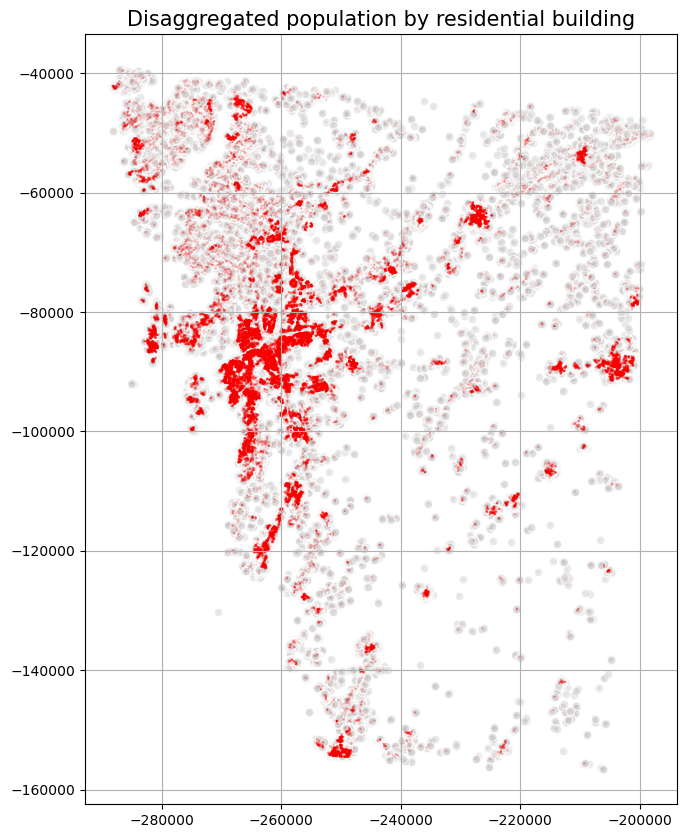

In [11]:
# A2. Map of population
# Size of the markers
marker_size_scale = 0.01

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot the base map - assuming population GeoDataFrame provides the base map context
population.plot(ax=ax, color='lightgrey', edgecolor='white', alpha=0.5)

# Plot the centroids with VALUE_disaggregated
joined_data.plot(ax=ax, color='red', markersize=joined_data['Pop_estimation'] * marker_size_scale, alpha=0.2)

# Normalize the data for color mapping
#norm = colors.Normalize(vmin=nodes_gdf[column_name].min(), vmax=nodes_gdf[column_name].max())
cmap = cm.viridis_r  # Use the reversed colormap

# Adding titles and labels
plt.title('Disaggregated population by residential building', fontsize=15)
plt.grid(True)
plt.show()

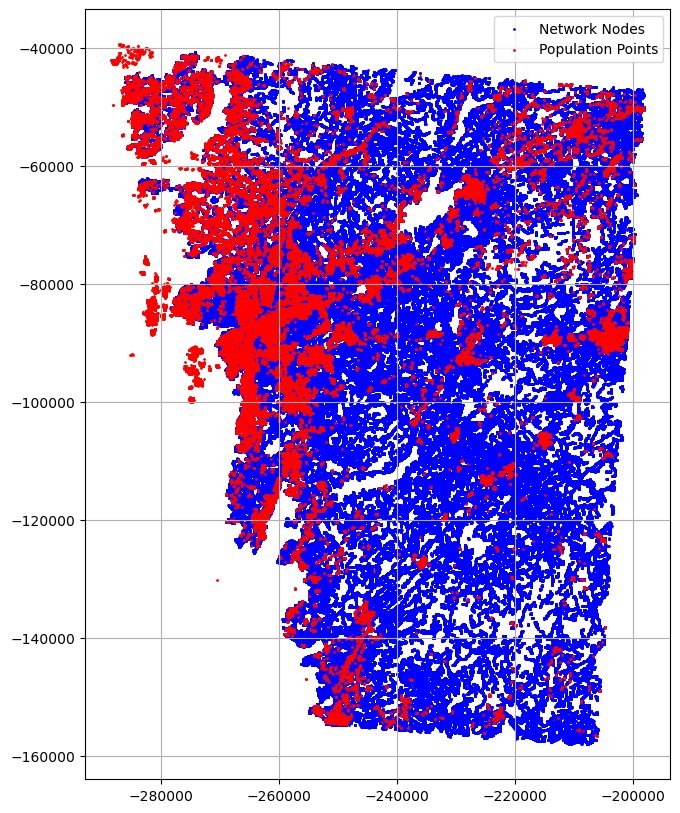

In [8]:
# A3. Nodes vs building centroids with population
# Visualize the network and the population points
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
nodes_gdf.plot(ax=ax, color='blue', markersize=1, label='Network Nodes')
population.plot(ax=ax, color='red', markersize=1, label='Population Points')
plt.legend()
plt.grid(True)
plt.show()

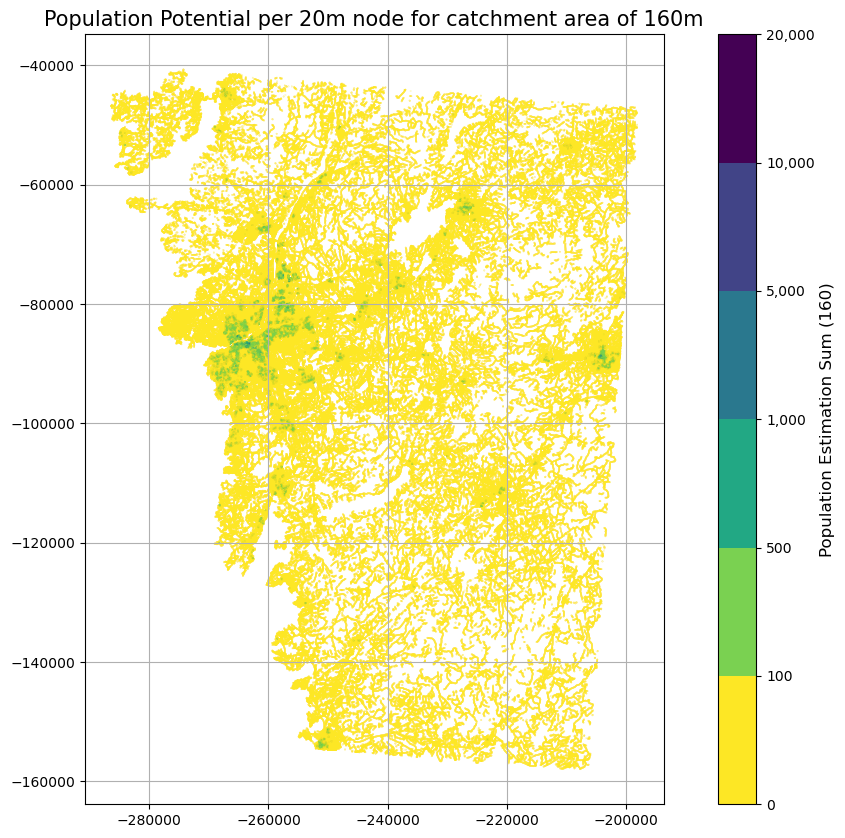

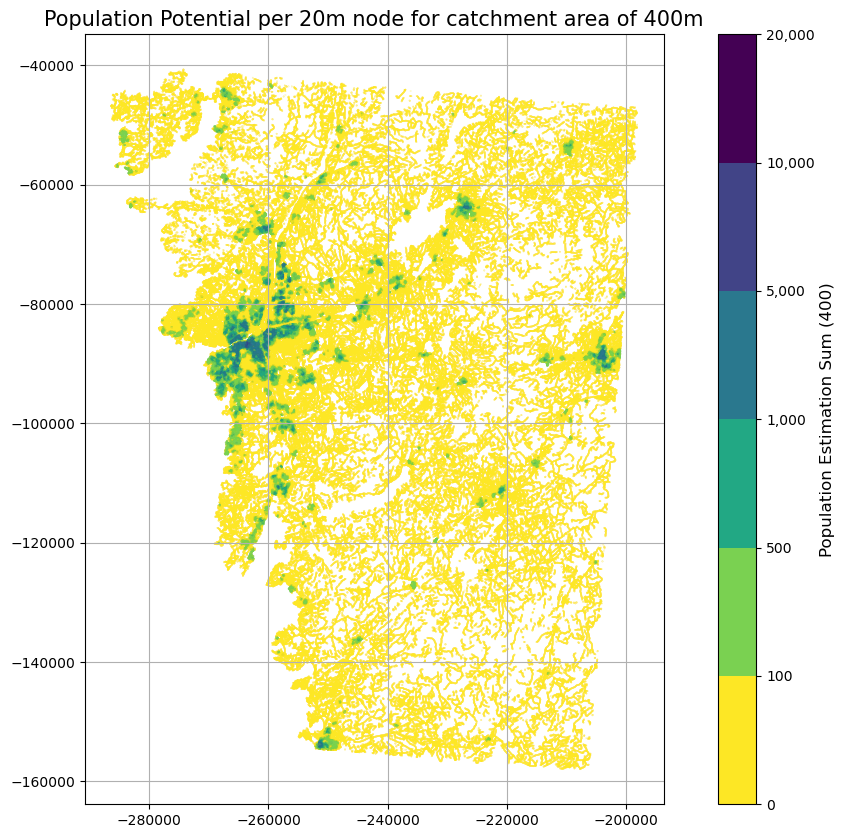

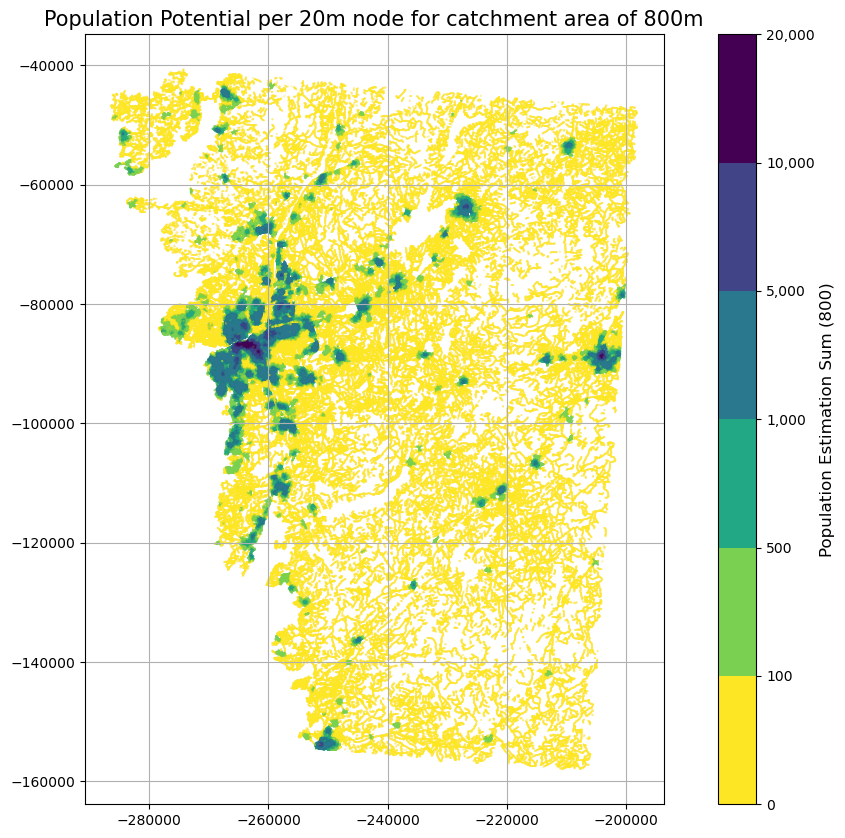

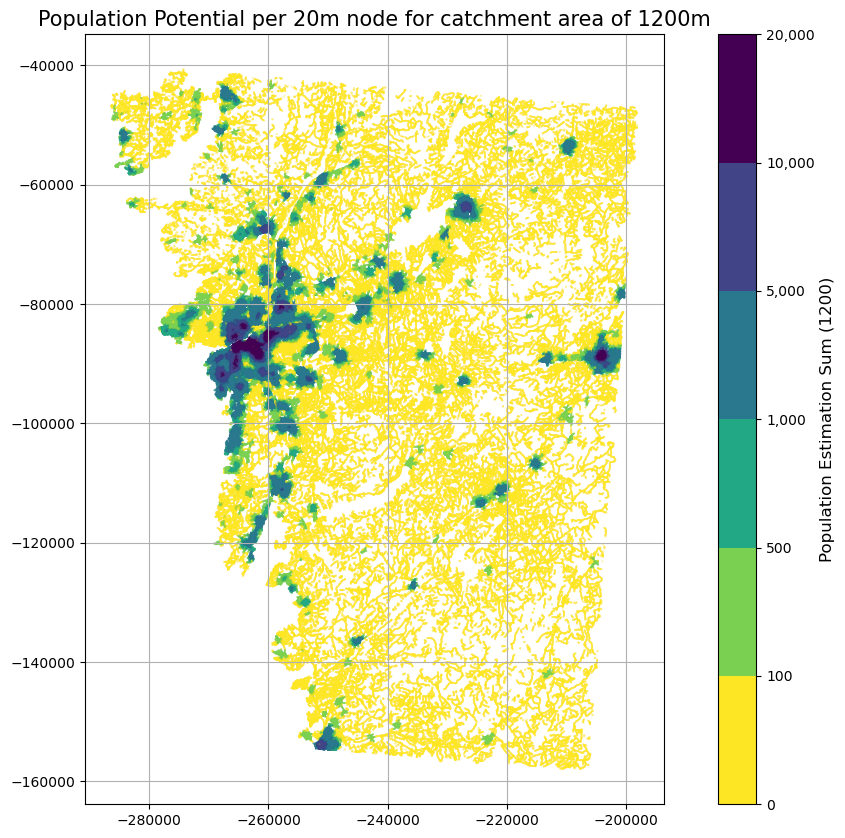

In [44]:
from matplotlib import cm, colors

# Define the bins
bins = [0, 100, 500, 1000, 5000, 10000, 20000]  # Adjust bins as needed

# Loop over each distance value
for i, distance_value in enumerate(distances):
    
    # Generate the column name dynamically
    column_name = f'cc_Pop_estimation_sum_{distance_value}_nw'

    # Size of the markers
    marker_size_scale = 0.01

    # Plotting the map
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    # Create a colormap and set the normalization using bins
    cmap = cm.viridis_r  # Use the reversed colormap
    norm = colors.BoundaryNorm(bins, ncolors=cmap.N, clip=True)

    # Plot the centroids with color mapping based on the dynamically generated column name
    nodes_gdf.plot(
        ax=ax,
        column=column_name,
        cmap=cmap,
        markersize=marker_size_scale,
        alpha=0.6,
        legend=False,
        norm=norm  # Apply the normalization
    )

    # Adding titles and labels
    plt.title(f'Population Potential per {points_distance}m node for catchment area of {distance_value}m', fontsize=15)
    plt.grid(True)

    # Adding color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(f'Population Estimation Sum ({distance_value})', fontsize=12)
    cbar.set_ticks(bins)  # Set ticks to match bin edges
    cbar.set_ticklabels([f'{b:,}' if b != 100000 else 'max' for b in bins])  # Replace 100000 with 'max'

    # Show the plot
    plt.show()


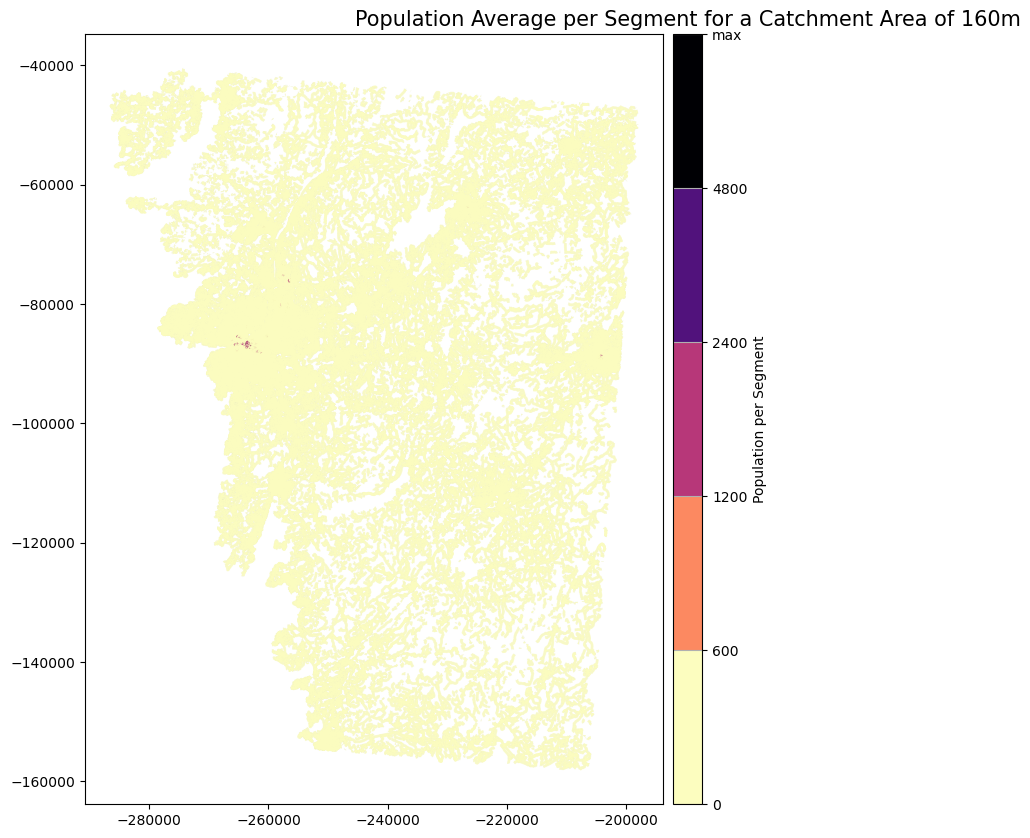

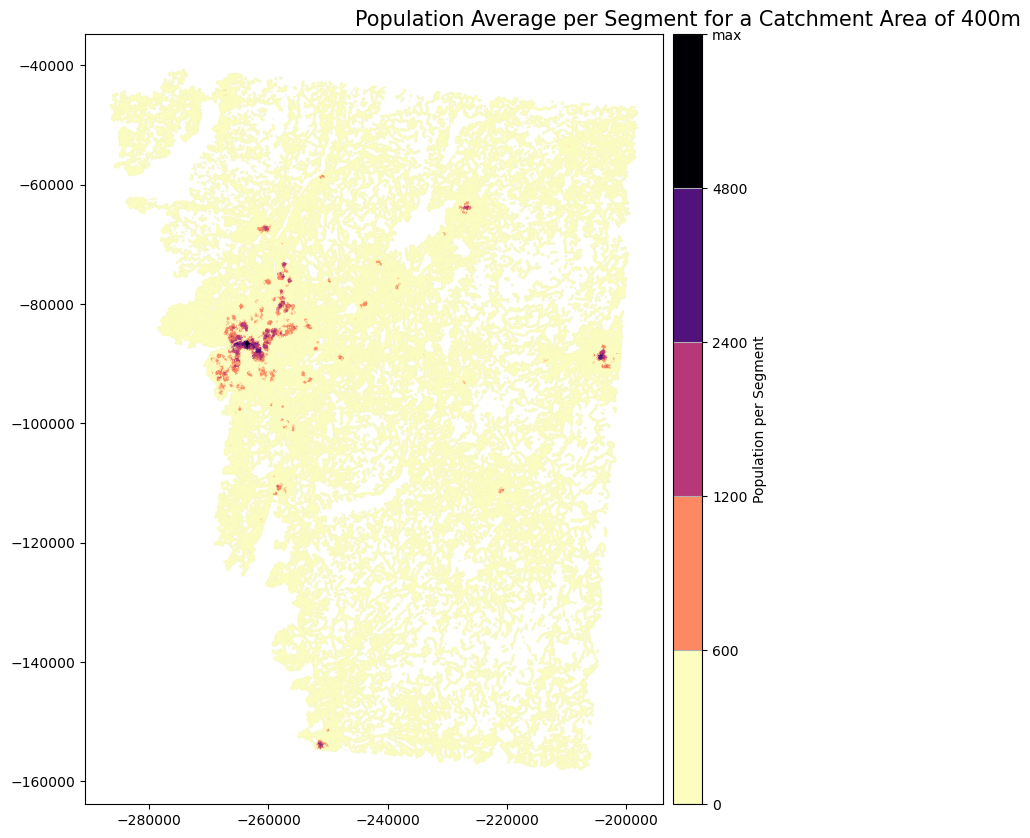

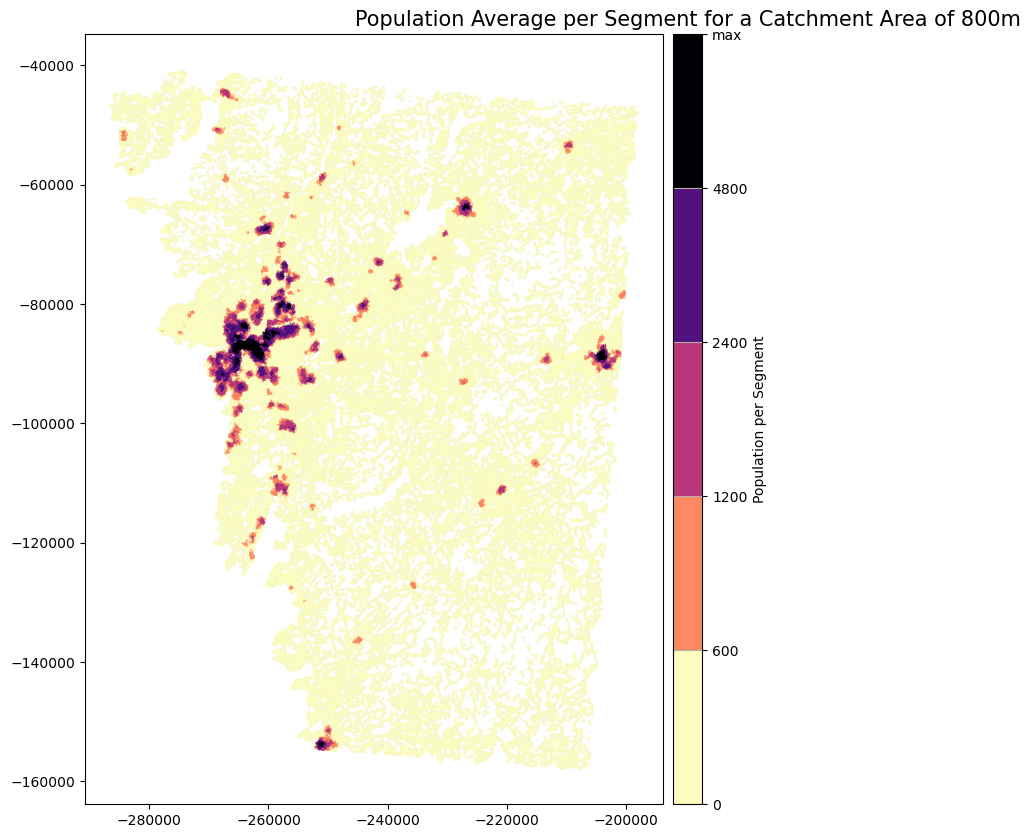

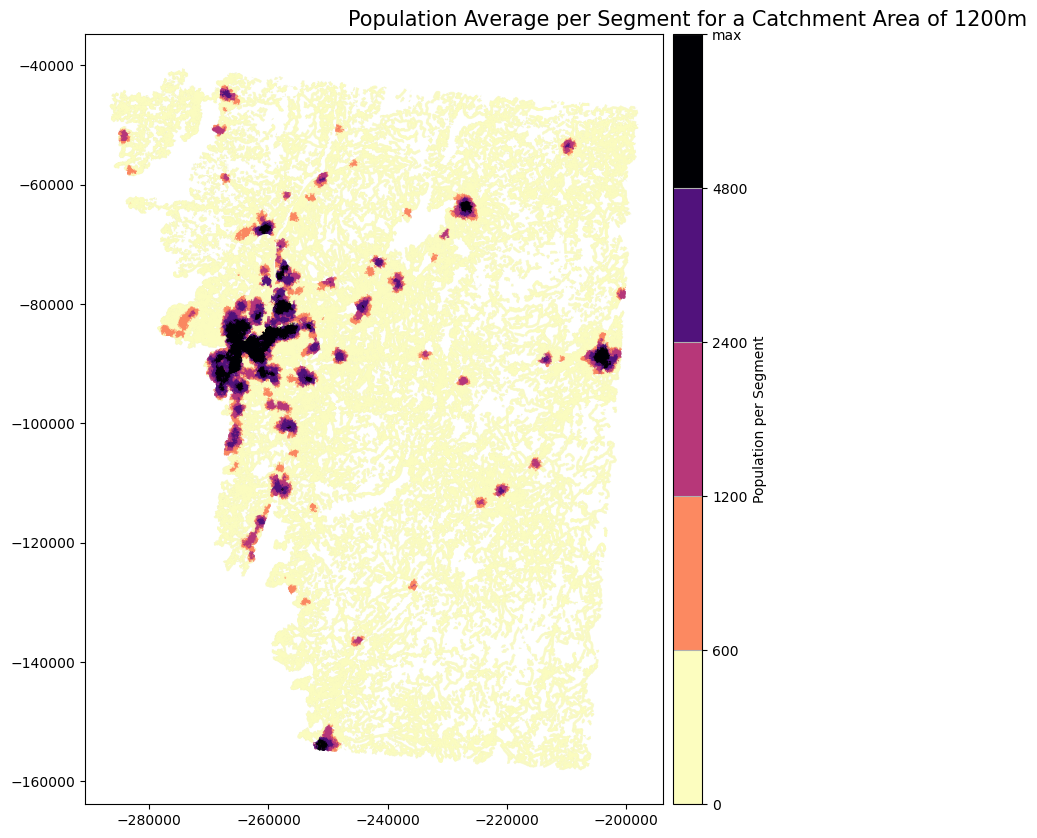

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Loop over each distance value
for i, distance_value in enumerate(distances):
    
    # Plotting the map
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plot the base map - assuming gdf provides the base map context
    gdf.plot(ax=ax, color='lightgrey', edgecolor='white', alpha=0.5)
    
    # Set the population bins for classification
    bins = [0, 600, 1200, 2400, 4800, 100000]
    
    # Create a colormap using the reversed magma colormap
    cmap = cm.magma_r
    norm = colors.BoundaryNorm(bins, ncolors=cmap.N, clip=True)
    
    # Classify the data into bins and apply the reversed magma colormap
    gdf['pop_bins'] = pd.cut(gdf[f'avg_pop_{distance_value}'], bins=bins, labels=False, include_lowest=True)
    
    # Plot the lines with width proportional to population and color based on bins
    gdf.plot(
        ax=ax,
        column='pop_bins',  # Use the classified population bins for color
        cmap=cmap,
        linewidth=2,  # Adjust as needed
        alpha=0.8
    )
    
    # Add a colorbar on the right side using the corrected color map and bins
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Empty array for the colorbar
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Population per Segment')
    
    # Update tick labels to replace '100000' with 'max'
    cbar.set_ticks(bins)  # Set ticks to match bin edges
    cbar.set_ticklabels(['0', '600', '1200', '2400', '4800', 'max'])
    
    # Adding titles and labels
    plt.title(f'Population Average per Segment for a Catchment Area of {distance_value}m', fontsize=15)
    plt.grid(True)
    
    # Show the plot
    plt.show()
